In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    !pip install -q transformers
    from google.colab import drive

    drive.mount('/content/drive')
    import sys

    sys.path.append('/content/drive/MyDrive/gan_bert_for_cpv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from transformers import logging
logging.set_verbosity_error()
import torch
from create_dataset import CreateDataset
from process_data import ProcessData
from utils import *

from torch.utils.data import DataLoader
from run_model import RunModel
from models import BertGenerator, BertDiscriminator
from transformers import AutoTokenizer, AutoModel, AutoConfig

In [3]:
from models import *

In [4]:
label_column = "afdeling"
text_column = "Korte beschrijving aanbesteding"

In [5]:
train_df = pd.read_csv("/content/drive/MyDrive/gan_bert_for_cpv/data/sampled_train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/gan_bert_for_cpv/data/sampled_test.csv")
translate_back=pd.read_csv("/content/drive/MyDrive/gan_bert_for_cpv/data/translate_back_all.csv")
vc2 = train_df[label_column].value_counts()

In [6]:
vc2

Furniture (incl. Meubelen (m.i.v. kantoormeubelen), inrichtingsartikelen, huishoudelijke apparaten (uitgez. verlichting) en schoonmaakproducten    970
Medische apparatuur, farmaceutische artikelen en artikelen voor lichaamsverzorging                                                                 970
Aardolieproducten, brandstof, elektriciteit en andere energiebronnen                                                                               970
Vervoersdiensten (uitg. vervoer van afval)                                                                                                         921
Diensten voor onderwijs en opleiding                                                                                                               841
Radio-, televisie-, communicatie-, telecommunicatietoestellen en aanverwante apparatuur                                                            816
Overige gemeenschaps-,  sociale en persoonlijke diensten                                      

In [7]:
down_sample_vc = vc2[vc2.values <300]
train_df = train_df[train_df[label_column].isin(down_sample_vc.index)]
test_df=test_df[test_df[label_column].isin(down_sample_vc.index)]
translate_back=translate_back[translate_back[label_column].isin(down_sample_vc.index)]

In [8]:
value_counts=train_df[label_column].value_counts()

In [9]:
value_counts

Ondersteunende en aanvullende vervoersdiensten; reisbureaudiensten                                   227
Landbouw- en veeteelt-, kwekerij-, visserij-, bosbouw- en aanverwante producten                      214
Chemische producten                                                                                  167
Muziekinstrumenten, sportartikelen, spelletjes, speelgoed, handwerk, kunstartikelen en toebehoren    153
Installatiediensten (uitgezonderd software)                                                          139
Openbare voorzieningen                                                                               108
Landbouwmachines                                                                                      90
Mijnbouw, basismetalen en aanverwante producten                                                       33
Machines voor de mijnbouw, steengroeven en voor de bouw                                               29
Name: afdeling, dtype: int64

In [10]:
all_df=pd.concat([train_df,test_df])

In [11]:
running_device = torch.device("cuda")

In [12]:
prd = ProcessData(all_df, label_column, text_column, sample_num=1000, aug_limit=1000, test_per_label_num=30,
                  drop_limit=50,
                  balanced_test=True)
_,_,_, label_encoder, onehot = prd.process()

After removing duplicate sentence: 1430
After drop cpv with low observations we have : 1430
The num of class is  9
The number of total data is:  1430
Total number of test data is:  270
Total number of train data is:  1154


In [13]:
model_runner = RunModel(running_device)
cd = CreateDataset(text_column, label_column, label_encoder, onehot, 3, running_device, max_length=120)
test_dataset = cd.create(test_df)
test_dl = DataLoader(test_dataset, shuffle=True, batch_size=20)
insuf_ds_dict = cd.create_label_dataset(train_df)
insuf_ds_list = list(insuf_ds_dict.values())

Init new bert


Getting bert hidden states from layer: 3: 100%|██████████| 167/167 [00:02<00:00, 79.36it/s]


In [14]:
tokenizer = AutoTokenizer.from_pretrained("GroNLP/bert-base-dutch-cased")
config = AutoConfig.from_pretrained("GroNLP/bert-base-dutch-cased", output_hidden_states=True)
bert = AutoModel.from_pretrained("GroNLP/bert-base-dutch-cased", config=config).to(running_device)

In [15]:
base_train_dataset = torch.utils.data.ConcatDataset(insuf_ds_list)
base_dl = DataLoader(base_train_dataset, shuffle=True, batch_size=20)
classifier = HiddenClassifier3(prd.num_class, bert)
classifier = model_runner.train_classifier(base_dl, test_dl, classifier, lr=3e-5, n_epochs=10)
# predictions, labels = model_runner.predict(test_dl, classifier)
# acc, f1, precision, recall, label_f1 = evaluate(labels, predictions)

100%|██████████| 58/58 [00:15<00:00,  3.70it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.111
F1: 0.022
Precision: 0.012
Recall: 0.111
0 acc:  0.1111111111111111 f1:  0.02222222222222222 precision 0.012345679012345678 recall 0.1111111111111111


100%|██████████| 58/58 [00:15<00:00,  3.65it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.215
F1: 0.112
Precision: 0.078
Recall: 0.215
1 acc:  0.21481481481481482 f1:  0.1124336709367302 precision 0.07795563246569087 recall 0.21481481481481482


100%|██████████| 58/58 [00:15<00:00,  3.63it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.496
F1: 0.393
Precision: 0.345
Recall: 0.496
2 acc:  0.4962962962962963 f1:  0.39311581172951887 precision 0.34506255770623584 recall 0.4962962962962963


100%|██████████| 58/58 [00:15<00:00,  3.65it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.507
F1: 0.400
Precision: 0.337
Recall: 0.507
3 acc:  0.5074074074074074 f1:  0.4002291755286603 precision 0.33703817042365225 recall 0.5074074074074075


100%|██████████| 58/58 [00:15<00:00,  3.66it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.585
F1: 0.495
Precision: 0.444
Recall: 0.585
4 acc:  0.5851851851851851 f1:  0.4950962993629315 precision 0.4442170981283366 recall 0.5851851851851851


100%|██████████| 58/58 [00:15<00:00,  3.66it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.585
F1: 0.502
Precision: 0.466
Recall: 0.585
5 acc:  0.5851851851851851 f1:  0.5018031202359929 precision 0.4657787496848008 recall 0.5851851851851853


100%|██████████| 58/58 [00:15<00:00,  3.65it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.600
F1: 0.520
Precision: 0.466
Recall: 0.600
6 acc:  0.6 f1:  0.5204131351538535 precision 0.4663035718857071 recall 0.6000000000000001


100%|██████████| 58/58 [00:15<00:00,  3.64it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.604
F1: 0.533
Precision: 0.480
Recall: 0.604
7 acc:  0.6037037037037037 f1:  0.5330429168704435 precision 0.47973820953984386 recall 0.6037037037037037


100%|██████████| 58/58 [00:15<00:00,  3.65it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.585
F1: 0.509
Precision: 0.473
Recall: 0.585
8 acc:  0.5851851851851851 f1:  0.5092072942370667 precision 0.4731285637944906 recall 0.5851851851851853


100%|██████████| 58/58 [00:15<00:00,  3.66it/s]


Total ACC: 0.622
F1: 0.550
Precision: 0.524
Recall: 0.622
9 acc:  0.6222222222222222 f1:  0.5496095773856551 precision 0.524224754189911 recall 0.6222222222222222


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
tbk_acc,gan_acc,hybrid_acc = [],[],[]
tbk_f1,gan_f1,hybrid_f1 = [],[],[]
tbk_recall,gan_recall,hybrid_recall = [],[],[]
tbk_precision,gan_precision,hybrid_precision = [],[],[]
tbk_all,gan_all,hybrid_all = [],[],[]
for i in range(1,9):
  sampled_df=translate_back.groupby(label_column, sort=False).sample(frac=float(i/8))
  sub_sample=sampled_df.groupby(label_column, sort=False).sample(frac=float(1/2))
  aug_limits = decide_aug_labels(False, None, value_counts,0.5*i)
  augmented_ds_lists = model_runner.augment_data(bert, aug_limits, insuf_ds_dict)
  half_augmented_ds_lists=[]
  for dataset in augmented_ds_lists:
      evens = list(range(0, len(dataset), 2))
      subdataset = torch.utils.data.Subset(dataset, evens)
      half_augmented_ds_lists.append(subdataset)
  tbk_aug_dataset = cd.create(sampled_df)
  sub_tbk_aug=cd.create(sub_sample)
  tbk_aug_train = torch.utils.data.ConcatDataset(insuf_ds_list+[tbk_aug_dataset])
  print(len(tbk_aug_train))
  gan_aug_train = torch.utils.data.ConcatDataset(insuf_ds_list+augmented_ds_lists)
  print(len(gan_aug_train))
  hybrid_train = torch.utils.data.ConcatDataset(insuf_ds_list+half_augmented_ds_lists+[sub_tbk_aug])
  print(len(hybrid_train))
  tbk_aug_dl = DataLoader(tbk_aug_train, shuffle=True, batch_size=40)

  gan_aug_dl = DataLoader(gan_aug_train, shuffle=True, batch_size=40)

  hybrid_dl = DataLoader(hybrid_train, shuffle=True, batch_size=40)

  classifier = HiddenClassifier3(prd.num_class, bert)
  classifier = model_runner.train_classifier(tbk_aug_dl, test_dl, classifier, lr=3e-5, n_epochs=10)
  predictions, labels = model_runner.predict(test_dl, classifier)
  acc, f1, precision, recall, label_f1 = evaluate(labels, predictions)
  tbk_acc.append(acc)
  tbk_f1.append(f1)
  tbk_recall.append(recall)
  tbk_precision.append(precision)
  tbk_all.append(label_f1)

  classifier = HiddenClassifier3(prd.num_class, bert)
  classifier = model_runner.train_classifier(gan_aug_dl, test_dl, classifier, lr=3e-5, n_epochs=10)
  predictions, labels = model_runner.predict(test_dl, classifier)
  acc, f1, precision, recall, label_f1 = evaluate(labels, predictions)
  gan_acc.append(acc)
  gan_f1.append(f1)
  gan_recall.append(recall)
  gan_precision.append(precision)
  gan_all.append(label_f1)
  classifier = HiddenClassifier3(prd.num_class, bert)
  classifier = model_runner.train_classifier(hybrid_dl, test_dl, classifier, lr=3e-5, n_epochs=10)
  predictions, labels = model_runner.predict(test_dl, classifier)
  acc, f1, precision, recall, label_f1 = evaluate(labels, predictions)

  hybrid_acc.append(acc)
  hybrid_f1.append(f1)
  hybrid_recall.append(recall)
  hybrid_precision.append(precision)
  hybrid_all.append(label_f1)


We have: 9 labels to be augmented


Getting bert hidden states from layer: 3: 100%|██████████| 290/290 [00:03<00:00, 79.25it/s]


1740
1680
1710


100%|██████████| 44/44 [00:23<00:00,  1.91it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.119
F1: 0.036
Precision: 0.124
Recall: 0.119
0 acc:  0.11851851851851852 f1:  0.03633557800224466 precision 0.12359550561797754 recall 0.11851851851851852


100%|██████████| 44/44 [00:23<00:00,  1.91it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.393
F1: 0.289
Precision: 0.251
Recall: 0.393
1 acc:  0.3925925925925926 f1:  0.28938531350564656 precision 0.2505668893265793 recall 0.3925925925925926


100%|██████████| 44/44 [00:23<00:00,  1.91it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.522
F1: 0.429
Precision: 0.398
Recall: 0.522
2 acc:  0.5222222222222223 f1:  0.4287561115158725 precision 0.39790705211765065 recall 0.5222222222222223


100%|██████████| 44/44 [00:23<00:00,  1.91it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.581
F1: 0.475
Precision: 0.409
Recall: 0.581
3 acc:  0.5814814814814815 f1:  0.4754759906185995 precision 0.40924347618572327 recall 0.5814814814814815


100%|██████████| 44/44 [00:23<00:00,  1.91it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.611
F1: 0.537
Precision: 0.489
Recall: 0.611
4 acc:  0.6111111111111112 f1:  0.5373379935198357 precision 0.48920340515168104 recall 0.6111111111111112


100%|██████████| 44/44 [00:23<00:00,  1.91it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.600
F1: 0.518
Precision: 0.493
Recall: 0.600
5 acc:  0.6 f1:  0.5178175256103915 precision 0.4930797709469219 recall 0.6000000000000001


100%|██████████| 44/44 [00:23<00:00,  1.91it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.626
F1: 0.558
Precision: 0.553
Recall: 0.626
6 acc:  0.6259259259259259 f1:  0.5582500516226494 precision 0.5534674235435055 recall 0.625925925925926


100%|██████████| 44/44 [00:23<00:00,  1.91it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.656
F1: 0.613
Precision: 0.607
Recall: 0.656
7 acc:  0.6555555555555556 f1:  0.6130962392147468 precision 0.6067661601690639 recall 0.6555555555555554


100%|██████████| 44/44 [00:23<00:00,  1.91it/s]


Total ACC: 0.667
F1: 0.626
Precision: 0.677
Recall: 0.667
8 acc:  0.6666666666666666 f1:  0.6259143222338336 precision 0.6766435476112895 recall 0.6666666666666666


100%|██████████| 44/44 [00:23<00:00,  1.91it/s]


Total ACC: 0.667
F1: 0.641
Precision: 0.684
Recall: 0.667
9 acc:  0.6666666666666666 f1:  0.6410082891689148 precision 0.6842433097083733 recall 0.6666666666666666
Total ACC: 0.667
F1: 0.641
Precision: 0.684
Recall: 0.667


100%|██████████| 42/42 [00:22<00:00,  1.91it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.126
F1: 0.048
Precision: 0.052
Recall: 0.126
0 acc:  0.1259259259259259 f1:  0.04778554778554778 precision 0.05226934523809524 recall 0.1259259259259259


100%|██████████| 42/42 [00:22<00:00,  1.91it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.259
F1: 0.132
Precision: 0.094
Recall: 0.259
1 acc:  0.25925925925925924 f1:  0.13246901174615588 precision 0.09408167413416758 recall 0.25925925925925924


100%|██████████| 42/42 [00:22<00:00,  1.91it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.456
F1: 0.360
Precision: 0.426
Recall: 0.456
2 acc:  0.45555555555555555 f1:  0.35974984800363835 precision 0.425972195903979 recall 0.4555555555555555


100%|██████████| 42/42 [00:22<00:00,  1.90it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.552
F1: 0.479
Precision: 0.467
Recall: 0.552
3 acc:  0.5518518518518518 f1:  0.479405079055161 precision 0.4672212339597397 recall 0.5518518518518519


100%|██████████| 42/42 [00:22<00:00,  1.90it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.604
F1: 0.526
Precision: 0.494
Recall: 0.604
4 acc:  0.6037037037037037 f1:  0.5264100777492895 precision 0.4943749135238497 recall 0.6037037037037037


100%|██████████| 42/42 [00:22<00:00,  1.90it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.615
F1: 0.543
Precision: 0.511
Recall: 0.615
5 acc:  0.6148148148148148 f1:  0.5426813171403889 precision 0.510979970936287 recall 0.6148148148148149


100%|██████████| 42/42 [00:22<00:00,  1.90it/s]


Total ACC: 0.630
F1: 0.559
Precision: 0.570
Recall: 0.630
6 acc:  0.6296296296296297 f1:  0.558636036466877 precision 0.570354123855304 recall 0.6296296296296297


100%|██████████| 42/42 [00:22<00:00,  1.90it/s]


Total ACC: 0.600
F1: 0.581
Precision: 0.651
Recall: 0.600
7 acc:  0.6 f1:  0.5814853783101638 precision 0.6508559648311201 recall 0.6


100%|██████████| 42/42 [00:22<00:00,  1.90it/s]


Total ACC: 0.696
F1: 0.660
Precision: 0.659
Recall: 0.696
8 acc:  0.6962962962962963 f1:  0.6601106053570842 precision 0.6594778886027092 recall 0.6962962962962963


100%|██████████| 42/42 [00:22<00:00,  1.90it/s]


Total ACC: 0.700
F1: 0.681
Precision: 0.711
Recall: 0.700
9 acc:  0.7 f1:  0.6805633123976437 precision 0.7114235616303795 recall 0.7
Total ACC: 0.700
F1: 0.681
Precision: 0.711
Recall: 0.700


100%|██████████| 43/43 [00:22<00:00,  1.91it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.133
F1: 0.048
Precision: 0.040
Recall: 0.133
0 acc:  0.13333333333333333 f1:  0.04848484848484849 precision 0.040272108843537414 recall 0.13333333333333333


100%|██████████| 43/43 [00:22<00:00,  1.91it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.326
F1: 0.204
Precision: 0.179
Recall: 0.326
1 acc:  0.32592592592592595 f1:  0.20447200452772796 precision 0.17918202364030508 recall 0.32592592592592595


100%|██████████| 43/43 [00:22<00:00,  1.91it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.504
F1: 0.408
Precision: 0.369
Recall: 0.504
2 acc:  0.5037037037037037 f1:  0.408121522608055 precision 0.36891850390357295 recall 0.5037037037037037


100%|██████████| 43/43 [00:22<00:00,  1.91it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.552
F1: 0.449
Precision: 0.385
Recall: 0.552
3 acc:  0.5518518518518518 f1:  0.4490344098695872 precision 0.38519970250978197 recall 0.5518518518518518


100%|██████████| 43/43 [00:22<00:00,  1.91it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.600
F1: 0.521
Precision: 0.468
Recall: 0.600
4 acc:  0.6 f1:  0.5205640365465976 precision 0.4675325421257045 recall 0.6000000000000001


100%|██████████| 43/43 [00:22<00:00,  1.91it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.600
F1: 0.522
Precision: 0.469
Recall: 0.600
5 acc:  0.6 f1:  0.521805004316487 precision 0.4686037309372117 recall 0.6000000000000001


100%|██████████| 43/43 [00:22<00:00,  1.91it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.596
F1: 0.524
Precision: 0.483
Recall: 0.596
6 acc:  0.5962962962962963 f1:  0.5244142473713708 precision 0.48256248859697126 recall 0.5962962962962963


100%|██████████| 43/43 [00:22<00:00,  1.91it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.596
F1: 0.526
Precision: 0.581
Recall: 0.596
7 acc:  0.5962962962962963 f1:  0.5263370448327171 precision 0.5805398088684978 recall 0.5962962962962963


100%|██████████| 43/43 [00:22<00:00,  1.91it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.648
F1: 0.580
Precision: 0.593
Recall: 0.648
8 acc:  0.6481481481481481 f1:  0.5797404431605653 precision 0.5930020248568636 recall 0.6481481481481481


100%|██████████| 43/43 [00:22<00:00,  1.91it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.637
F1: 0.586
Precision: 0.607
Recall: 0.637
9 acc:  0.6370370370370371 f1:  0.5864445221549822 precision 0.6068035223662515 recall 0.6370370370370371


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.637
F1: 0.586
Precision: 0.607
Recall: 0.637
We have: 9 labels to be augmented


Getting bert hidden states from layer: 3: 100%|██████████| 580/580 [00:07<00:00, 80.79it/s]


2320
2220
2270


100%|██████████| 58/58 [00:30<00:00,  1.90it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.159
F1: 0.058
Precision: 0.036
Recall: 0.159
0 acc:  0.15925925925925927 f1:  0.0575986923924244 precision 0.03603341103341103 recall 0.15925925925925927


100%|██████████| 58/58 [00:30<00:00,  1.90it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.452
F1: 0.331
Precision: 0.267
Recall: 0.452
1 acc:  0.45185185185185184 f1:  0.3314984643796639 precision 0.2673208192490503 recall 0.45185185185185184


100%|██████████| 58/58 [00:30<00:00,  1.90it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.533
F1: 0.451
Precision: 0.421
Recall: 0.533
2 acc:  0.5333333333333333 f1:  0.45058444954465493 precision 0.42060862189426934 recall 0.5333333333333333


100%|██████████| 58/58 [00:30<00:00,  1.90it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.574
F1: 0.471
Precision: 0.425
Recall: 0.574
3 acc:  0.5740740740740741 f1:  0.4711173957361321 precision 0.4254021305491894 recall 0.574074074074074


100%|██████████| 58/58 [00:30<00:00,  1.90it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.578
F1: 0.505
Precision: 0.459
Recall: 0.578
4 acc:  0.5777777777777777 f1:  0.504568730931395 precision 0.4586778314810377 recall 0.5777777777777778


100%|██████████| 58/58 [00:30<00:00,  1.90it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.648
F1: 0.590
Precision: 0.610
Recall: 0.648
5 acc:  0.6481481481481481 f1:  0.5904433071535062 precision 0.6095408242467066 recall 0.6481481481481481


100%|██████████| 58/58 [00:30<00:00,  1.90it/s]


Total ACC: 0.652
F1: 0.616
Precision: 0.615
Recall: 0.652
6 acc:  0.6518518518518519 f1:  0.6158348777214266 precision 0.6149823387838527 recall 0.6518518518518519


100%|██████████| 58/58 [00:30<00:00,  1.90it/s]


Total ACC: 0.674
F1: 0.641
Precision: 0.729
Recall: 0.674
7 acc:  0.674074074074074 f1:  0.6405195972168907 precision 0.7287157058550588 recall 0.6740740740740742


100%|██████████| 58/58 [00:30<00:00,  1.90it/s]


Total ACC: 0.700
F1: 0.680
Precision: 0.724
Recall: 0.700
8 acc:  0.7 f1:  0.6796731920270958 precision 0.7238724918871977 recall 0.6999999999999998


100%|██████████| 58/58 [00:30<00:00,  1.90it/s]


Total ACC: 0.719
F1: 0.704
Precision: 0.739
Recall: 0.719
9 acc:  0.7185185185185186 f1:  0.7037147858895911 precision 0.7386625074120461 recall 0.7185185185185186
Total ACC: 0.719
F1: 0.704
Precision: 0.739
Recall: 0.719


100%|██████████| 56/56 [00:29<00:00,  1.91it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.163
F1: 0.059
Precision: 0.036
Recall: 0.163
0 acc:  0.16296296296296298 f1:  0.05942478183280859 precision 0.036343444328506655 recall 0.16296296296296298


100%|██████████| 56/56 [00:29<00:00,  1.91it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.367
F1: 0.242
Precision: 0.196
Recall: 0.367
1 acc:  0.36666666666666664 f1:  0.24227488818533593 precision 0.19612760335154558 recall 0.36666666666666664


100%|██████████| 56/56 [00:29<00:00,  1.91it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.563
F1: 0.473
Precision: 0.457
Recall: 0.563
2 acc:  0.562962962962963 f1:  0.47326906642824235 precision 0.4570241451372159 recall 0.562962962962963


100%|██████████| 56/56 [00:29<00:00,  1.91it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.578
F1: 0.501
Precision: 0.475
Recall: 0.578
3 acc:  0.5777777777777777 f1:  0.5010490321055676 precision 0.4751544104197283 recall 0.5777777777777778


100%|██████████| 56/56 [00:29<00:00,  1.91it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.626
F1: 0.550
Precision: 0.503
Recall: 0.626
4 acc:  0.6259259259259259 f1:  0.5503449226167153 precision 0.5026519374345462 recall 0.6259259259259259


100%|██████████| 56/56 [00:29<00:00,  1.91it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.607
F1: 0.547
Precision: 0.574
Recall: 0.607
5 acc:  0.6074074074074074 f1:  0.5468579571571877 precision 0.5741787193157839 recall 0.6074074074074074


100%|██████████| 56/56 [00:29<00:00,  1.91it/s]


Total ACC: 0.685
F1: 0.643
Precision: 0.678
Recall: 0.685
6 acc:  0.6851851851851852 f1:  0.6426599298011838 precision 0.6778065847250907 recall 0.6851851851851852


100%|██████████| 56/56 [00:29<00:00,  1.91it/s]


Total ACC: 0.715
F1: 0.704
Precision: 0.708
Recall: 0.715
7 acc:  0.7148148148148148 f1:  0.7043404403024127 precision 0.7075643752714336 recall 0.7148148148148148


100%|██████████| 56/56 [00:29<00:00,  1.91it/s]


Total ACC: 0.704
F1: 0.696
Precision: 0.719
Recall: 0.704
8 acc:  0.7037037037037037 f1:  0.6957597174111311 precision 0.7190651751023268 recall 0.7037037037037037


100%|██████████| 56/56 [00:29<00:00,  1.91it/s]


Total ACC: 0.696
F1: 0.681
Precision: 0.708
Recall: 0.696
9 acc:  0.6962962962962963 f1:  0.6813780623798771 precision 0.7083371267808328 recall 0.6962962962962963
Total ACC: 0.696
F1: 0.681
Precision: 0.708
Recall: 0.696


100%|██████████| 57/57 [00:29<00:00,  1.90it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.126
F1: 0.046
Precision: 0.028
Recall: 0.126
0 acc:  0.1259259259259259 f1:  0.04552310434663376 precision 0.027920260037953518 recall 0.1259259259259259


100%|██████████| 57/57 [00:29<00:00,  1.90it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.396
F1: 0.284
Precision: 0.232
Recall: 0.396
1 acc:  0.3962962962962963 f1:  0.2839253545806434 precision 0.23197647594457166 recall 0.39629629629629626


100%|██████████| 57/57 [00:29<00:00,  1.90it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.578
F1: 0.494
Precision: 0.517
Recall: 0.578
2 acc:  0.5777777777777777 f1:  0.4938555549610194 precision 0.5171847886324286 recall 0.5777777777777778


100%|██████████| 57/57 [00:29<00:00,  1.90it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.619
F1: 0.539
Precision: 0.489
Recall: 0.619
3 acc:  0.6185185185185185 f1:  0.5388342985397715 precision 0.48862730910945223 recall 0.6185185185185185


100%|██████████| 57/57 [00:29<00:00,  1.90it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.574
F1: 0.504
Precision: 0.471
Recall: 0.574
4 acc:  0.5740740740740741 f1:  0.5037408050340673 precision 0.47095665842889417 recall 0.574074074074074


100%|██████████| 57/57 [00:29<00:00,  1.90it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.596
F1: 0.522
Precision: 0.468
Recall: 0.596
5 acc:  0.5962962962962963 f1:  0.5220307707833471 precision 0.46776081845426654 recall 0.5962962962962963


100%|██████████| 57/57 [00:29<00:00,  1.90it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.585
F1: 0.514
Precision: 0.478
Recall: 0.585
6 acc:  0.5851851851851851 f1:  0.5135507317983348 precision 0.4779002514936953 recall 0.5851851851851851


100%|██████████| 57/57 [00:29<00:00,  1.90it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.626
F1: 0.583
Precision: 0.585
Recall: 0.626
7 acc:  0.6259259259259259 f1:  0.5825617298834777 precision 0.5852566441646901 recall 0.6259259259259259


100%|██████████| 57/57 [00:29<00:00,  1.90it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.656
F1: 0.611
Precision: 0.587
Recall: 0.656
8 acc:  0.6555555555555556 f1:  0.6111156207122225 precision 0.587401692320853 recall 0.6555555555555556


100%|██████████| 57/57 [00:29<00:00,  1.90it/s]


Total ACC: 0.667
F1: 0.625
Precision: 0.605
Recall: 0.667
9 acc:  0.6666666666666666 f1:  0.6247271146984454 precision 0.6046340439684466 recall 0.6666666666666666
Total ACC: 0.667
F1: 0.625
Precision: 0.605
Recall: 0.667
We have: 9 labels to be augmented


Getting bert hidden states from layer: 3: 100%|██████████| 870/870 [00:10<00:00, 80.13it/s]


2900
2840
2870


100%|██████████| 73/73 [00:38<00:00,  1.90it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.204
F1: 0.078
Precision: 0.049
Recall: 0.204
0 acc:  0.2037037037037037 f1:  0.07831408140814082 precision 0.04918789221114803 recall 0.20370370370370372


100%|██████████| 73/73 [00:38<00:00,  1.90it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.441
F1: 0.327
Precision: 0.270
Recall: 0.441
1 acc:  0.44074074074074077 f1:  0.3265141472766273 precision 0.26952644202988796 recall 0.44074074074074077


100%|██████████| 73/73 [00:38<00:00,  1.90it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.507
F1: 0.425
Precision: 0.403
Recall: 0.507
2 acc:  0.5074074074074074 f1:  0.4248244303547941 precision 0.40275155238695487 recall 0.5074074074074074


100%|██████████| 73/73 [00:38<00:00,  1.90it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.604
F1: 0.525
Precision: 0.470
Recall: 0.604
3 acc:  0.6037037037037037 f1:  0.5252045324624032 precision 0.4703311110905763 recall 0.6037037037037037


100%|██████████| 73/73 [00:38<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.626
F1: 0.554
Precision: 0.598
Recall: 0.626
4 acc:  0.6259259259259259 f1:  0.5536493940551813 precision 0.598343743012224 recall 0.625925925925926


100%|██████████| 73/73 [00:38<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.663
F1: 0.615
Precision: 0.603
Recall: 0.663
5 acc:  0.662962962962963 f1:  0.6148539068644424 precision 0.6034673942568679 recall 0.662962962962963


100%|██████████| 73/73 [00:38<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.704
F1: 0.658
Precision: 0.633
Recall: 0.704
6 acc:  0.7037037037037037 f1:  0.6583494433246287 precision 0.6334042634767273 recall 0.7037037037037037


100%|██████████| 73/73 [00:38<00:00,  1.89it/s]


Total ACC: 0.722
F1: 0.687
Precision: 0.706
Recall: 0.722
7 acc:  0.7222222222222222 f1:  0.6872852881570977 precision 0.7062479328110837 recall 0.7222222222222223


100%|██████████| 73/73 [00:38<00:00,  1.89it/s]


Total ACC: 0.681
F1: 0.651
Precision: 0.676
Recall: 0.681
8 acc:  0.6814814814814815 f1:  0.6507718517291396 precision 0.6758015103168769 recall 0.6814814814814815


100%|██████████| 73/73 [00:38<00:00,  1.90it/s]


Total ACC: 0.737
F1: 0.731
Precision: 0.739
Recall: 0.737
9 acc:  0.737037037037037 f1:  0.7311573770929564 precision 0.7385020545839259 recall 0.737037037037037
Total ACC: 0.737
F1: 0.731
Precision: 0.739
Recall: 0.737


100%|██████████| 71/71 [00:37<00:00,  1.90it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.156
F1: 0.080
Precision: 0.116
Recall: 0.156
0 acc:  0.15555555555555556 f1:  0.07988826595383973 precision 0.11627914101032381 recall 0.15555555555555556


100%|██████████| 71/71 [00:37<00:00,  1.90it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.393
F1: 0.294
Precision: 0.253
Recall: 0.393
1 acc:  0.3925925925925926 f1:  0.29375884448348216 precision 0.25260283324799454 recall 0.3925925925925926


100%|██████████| 71/71 [00:37<00:00,  1.90it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.500
F1: 0.414
Precision: 0.363
Recall: 0.500
2 acc:  0.5 f1:  0.4140394101258705 precision 0.3633573974181185 recall 0.5


100%|██████████| 71/71 [00:37<00:00,  1.90it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.511
F1: 0.428
Precision: 0.375
Recall: 0.511
3 acc:  0.5111111111111111 f1:  0.4281193773731087 precision 0.3746444929778263 recall 0.5111111111111111


100%|██████████| 71/71 [00:37<00:00,  1.90it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.537
F1: 0.452
Precision: 0.504
Recall: 0.537
4 acc:  0.5370370370370371 f1:  0.45177308052553833 precision 0.5038726735376202 recall 0.537037037037037


100%|██████████| 71/71 [00:37<00:00,  1.90it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.556
F1: 0.499
Precision: 0.502
Recall: 0.556
5 acc:  0.5555555555555556 f1:  0.4987001333184261 precision 0.5024265638042729 recall 0.5555555555555555


100%|██████████| 71/71 [00:37<00:00,  1.90it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.611
F1: 0.574
Precision: 0.545
Recall: 0.611
6 acc:  0.6111111111111112 f1:  0.5737280226064058 precision 0.5447250395991361 recall 0.6111111111111112


100%|██████████| 71/71 [00:37<00:00,  1.90it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.633
F1: 0.604
Precision: 0.591
Recall: 0.633
7 acc:  0.6333333333333333 f1:  0.6035114310830925 precision 0.5913762786483684 recall 0.6333333333333334


100%|██████████| 71/71 [00:37<00:00,  1.90it/s]


Total ACC: 0.696
F1: 0.688
Precision: 0.722
Recall: 0.696
8 acc:  0.6962962962962963 f1:  0.6881820275605937 precision 0.7217689294974886 recall 0.6962962962962963


100%|██████████| 71/71 [00:37<00:00,  1.90it/s]


Total ACC: 0.719
F1: 0.709
Precision: 0.728
Recall: 0.719
9 acc:  0.7185185185185186 f1:  0.7091863992896786 precision 0.7282974367017195 recall 0.7185185185185187
Total ACC: 0.719
F1: 0.709
Precision: 0.728
Recall: 0.719


100%|██████████| 72/72 [00:37<00:00,  1.90it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.326
F1: 0.197
Precision: 0.146
Recall: 0.326
0 acc:  0.32592592592592595 f1:  0.19682061524455002 precision 0.14593451137679023 recall 0.3259259259259259


100%|██████████| 72/72 [00:37<00:00,  1.90it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.537
F1: 0.464
Precision: 0.434
Recall: 0.537
1 acc:  0.5370370370370371 f1:  0.4637009755651056 precision 0.43445728023715197 recall 0.537037037037037


100%|██████████| 72/72 [00:37<00:00,  1.90it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.607
F1: 0.527
Precision: 0.480
Recall: 0.607
2 acc:  0.6074074074074074 f1:  0.5272519649640022 precision 0.47991283796013007 recall 0.6074074074074074


100%|██████████| 72/72 [00:37<00:00,  1.90it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.593
F1: 0.520
Precision: 0.480
Recall: 0.593
3 acc:  0.5925925925925926 f1:  0.5202896303193673 precision 0.48040587559025066 recall 0.5925925925925926


100%|██████████| 72/72 [00:37<00:00,  1.90it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.615
F1: 0.545
Precision: 0.546
Recall: 0.615
4 acc:  0.6148148148148148 f1:  0.5445955446713227 precision 0.5455787620087823 recall 0.6148148148148148


100%|██████████| 72/72 [00:37<00:00,  1.90it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.619
F1: 0.569
Precision: 0.570
Recall: 0.619
5 acc:  0.6185185185185185 f1:  0.569277277174614 precision 0.56955710141194 recall 0.6185185185185186


100%|██████████| 72/72 [00:37<00:00,  1.90it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.659
F1: 0.612
Precision: 0.583
Recall: 0.659
6 acc:  0.6592592592592592 f1:  0.6117000308389505 precision 0.582875246447901 recall 0.6592592592592593


100%|██████████| 72/72 [00:37<00:00,  1.90it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.667
F1: 0.628
Precision: 0.612
Recall: 0.667
7 acc:  0.6666666666666666 f1:  0.6284713397212606 precision 0.6121535251996617 recall 0.6666666666666666


100%|██████████| 72/72 [00:37<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.637
F1: 0.598
Precision: 0.581
Recall: 0.637
8 acc:  0.6370370370370371 f1:  0.5982711739040282 precision 0.5806841574569014 recall 0.6370370370370371


100%|██████████| 72/72 [00:38<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.681
F1: 0.639
Precision: 0.608
Recall: 0.681
9 acc:  0.6814814814814815 f1:  0.6385528648942849 precision 0.608439405893302 recall 0.6814814814814815


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.681
F1: 0.639
Precision: 0.608
Recall: 0.681
We have: 9 labels to be augmented


Getting bert hidden states from layer: 3: 100%|██████████| 1160/1160 [00:15<00:00, 75.96it/s]


3480
3380
3430


100%|██████████| 87/87 [00:46<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.230
F1: 0.120
Precision: 0.087
Recall: 0.230
0 acc:  0.22962962962962963 f1:  0.12010857807645037 precision 0.08652413194004975 recall 0.22962962962962966


100%|██████████| 87/87 [00:46<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.463
F1: 0.350
Precision: 0.300
Recall: 0.463
1 acc:  0.46296296296296297 f1:  0.3503398045077207 precision 0.2999289682008449 recall 0.462962962962963


100%|██████████| 87/87 [00:46<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.570
F1: 0.487
Precision: 0.452
Recall: 0.570
2 acc:  0.5703703703703704 f1:  0.48705942334603325 precision 0.4524567987966145 recall 0.5703703703703704


100%|██████████| 87/87 [00:46<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.626
F1: 0.555
Precision: 0.607
Recall: 0.626
3 acc:  0.6259259259259259 f1:  0.555277594671926 precision 0.6074583807008485 recall 0.625925925925926


100%|██████████| 87/87 [00:46<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.685
F1: 0.643
Precision: 0.613
Recall: 0.685
4 acc:  0.6851851851851852 f1:  0.6425379146598996 precision 0.6129676649837941 recall 0.6851851851851852


100%|██████████| 87/87 [00:46<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.667
F1: 0.628
Precision: 0.605
Recall: 0.667
5 acc:  0.6666666666666666 f1:  0.6281854069278983 precision 0.6052494941987695 recall 0.6666666666666666


100%|██████████| 87/87 [00:46<00:00,  1.88it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.685
F1: 0.644
Precision: 0.623
Recall: 0.685
6 acc:  0.6851851851851852 f1:  0.6443731186966585 precision 0.6227650643898851 recall 0.6851851851851852


100%|██████████| 87/87 [00:46<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.678
F1: 0.632
Precision: 0.614
Recall: 0.678
7 acc:  0.6777777777777778 f1:  0.6315302414404653 precision 0.6140395777521342 recall 0.6777777777777778


100%|██████████| 87/87 [00:46<00:00,  1.89it/s]


Total ACC: 0.700
F1: 0.669
Precision: 0.746
Recall: 0.700
8 acc:  0.7 f1:  0.6688585404691061 precision 0.7460971439251582 recall 0.7000000000000001


100%|██████████| 87/87 [00:46<00:00,  1.89it/s]


Total ACC: 0.696
F1: 0.677
Precision: 0.717
Recall: 0.696
9 acc:  0.6962962962962963 f1:  0.6765221064434171 precision 0.7173387395007622 recall 0.6962962962962963
Total ACC: 0.696
F1: 0.677
Precision: 0.717
Recall: 0.696


100%|██████████| 85/85 [00:44<00:00,  1.90it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.200
F1: 0.112
Precision: 0.093
Recall: 0.200
0 acc:  0.2 f1:  0.1123585123585124 precision 0.09305555555555556 recall 0.19999999999999998


100%|██████████| 85/85 [00:44<00:00,  1.91it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.422
F1: 0.316
Precision: 0.264
Recall: 0.422
1 acc:  0.4222222222222222 f1:  0.3162617436038893 precision 0.2637514288924481 recall 0.4222222222222222


100%|██████████| 85/85 [00:44<00:00,  1.92it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.456
F1: 0.373
Precision: 0.345
Recall: 0.456
2 acc:  0.45555555555555555 f1:  0.37300514583921046 precision 0.3453586150530361 recall 0.4555555555555555


100%|██████████| 85/85 [00:44<00:00,  1.91it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.504
F1: 0.434
Precision: 0.395
Recall: 0.504
3 acc:  0.5037037037037037 f1:  0.4343899995079344 precision 0.3954926506715584 recall 0.5037037037037037


100%|██████████| 85/85 [00:44<00:00,  1.90it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.548
F1: 0.466
Precision: 0.464
Recall: 0.548
4 acc:  0.5481481481481482 f1:  0.46600100465110067 precision 0.4643340107002359 recall 0.5481481481481482


100%|██████████| 85/85 [00:44<00:00,  1.91it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.593
F1: 0.532
Precision: 0.514
Recall: 0.593
5 acc:  0.5925925925925926 f1:  0.5319388421189128 precision 0.5140019484239731 recall 0.5925925925925927


100%|██████████| 85/85 [00:44<00:00,  1.91it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.615
F1: 0.552
Precision: 0.531
Recall: 0.615
6 acc:  0.6148148148148148 f1:  0.5523459207524279 precision 0.5311335550189171 recall 0.6148148148148148


100%|██████████| 85/85 [00:44<00:00,  1.91it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.563
F1: 0.498
Precision: 0.506
Recall: 0.563
7 acc:  0.562962962962963 f1:  0.49822506773341524 precision 0.5059007163512795 recall 0.5629629629629629


100%|██████████| 85/85 [00:44<00:00,  1.91it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.593
F1: 0.525
Precision: 0.486
Recall: 0.593
8 acc:  0.5925925925925926 f1:  0.5250234252544462 precision 0.48609737314341955 recall 0.5925925925925927


100%|██████████| 85/85 [00:44<00:00,  1.91it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.574
F1: 0.515
Precision: 0.517
Recall: 0.574
9 acc:  0.5740740740740741 f1:  0.5153394417001893 precision 0.5166976006158889 recall 0.5740740740740741


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.574
F1: 0.515
Precision: 0.517
Recall: 0.574


100%|██████████| 86/86 [00:45<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.256
F1: 0.152
Precision: 0.162
Recall: 0.256
0 acc:  0.25555555555555554 f1:  0.15175458308437031 precision 0.16181118968004213 recall 0.25555555555555554


100%|██████████| 86/86 [00:45<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.589
F1: 0.512
Precision: 0.481
Recall: 0.589
1 acc:  0.5888888888888889 f1:  0.5115950223549273 precision 0.4809457465898715 recall 0.588888888888889


100%|██████████| 86/86 [00:45<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.596
F1: 0.522
Precision: 0.475
Recall: 0.596
2 acc:  0.5962962962962963 f1:  0.5215536175578589 precision 0.475101197679822 recall 0.5962962962962962


100%|██████████| 86/86 [00:45<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.626
F1: 0.544
Precision: 0.486
Recall: 0.626
3 acc:  0.6259259259259259 f1:  0.5440315006765364 precision 0.4861164777831445 recall 0.625925925925926


100%|██████████| 86/86 [00:45<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.607
F1: 0.534
Precision: 0.525
Recall: 0.607
4 acc:  0.6074074074074074 f1:  0.5344543151545716 precision 0.5246694292730099 recall 0.6074074074074074


100%|██████████| 86/86 [00:45<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.644
F1: 0.598
Precision: 0.567
Recall: 0.644
5 acc:  0.6444444444444445 f1:  0.5978172069016967 precision 0.5672850469598436 recall 0.6444444444444444


100%|██████████| 86/86 [00:45<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.633
F1: 0.587
Precision: 0.552
Recall: 0.633
6 acc:  0.6333333333333333 f1:  0.5866329691371437 precision 0.5522344974253468 recall 0.6333333333333333


100%|██████████| 86/86 [00:45<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.630
F1: 0.588
Precision: 0.586
Recall: 0.630
7 acc:  0.6296296296296297 f1:  0.5881601511464212 precision 0.5864057239057239 recall 0.6296296296296297


100%|██████████| 86/86 [00:45<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.619
F1: 0.567
Precision: 0.553
Recall: 0.619
8 acc:  0.6185185185185185 f1:  0.5666747650215834 precision 0.5525360047430827 recall 0.6185185185185186


100%|██████████| 86/86 [00:45<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.659
F1: 0.611
Precision: 0.578
Recall: 0.659
9 acc:  0.6592592592592592 f1:  0.6106933345051586 precision 0.5775294539407443 recall 0.6592592592592593


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.659
F1: 0.611
Precision: 0.578
Recall: 0.659
We have: 9 labels to be augmented


Getting bert hidden states from layer: 3: 100%|██████████| 1450/1450 [00:18<00:00, 77.48it/s]


4060
3979
4020


100%|██████████| 102/102 [00:53<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.278
F1: 0.139
Precision: 0.094
Recall: 0.278
0 acc:  0.2777777777777778 f1:  0.13885338078886467 precision 0.09393983469800954 recall 0.2777777777777778


100%|██████████| 102/102 [00:54<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.537
F1: 0.430
Precision: 0.362
Recall: 0.537
1 acc:  0.5370370370370371 f1:  0.42966981730475146 precision 0.3621275369209086 recall 0.537037037037037


100%|██████████| 102/102 [00:53<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.607
F1: 0.526
Precision: 0.484
Recall: 0.607
2 acc:  0.6074074074074074 f1:  0.5256496098925586 precision 0.4842999808049715 recall 0.6074074074074074


100%|██████████| 102/102 [00:53<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.652
F1: 0.595
Precision: 0.623
Recall: 0.652
3 acc:  0.6518518518518519 f1:  0.5953264400491146 precision 0.6226262514701455 recall 0.6518518518518519


100%|██████████| 102/102 [00:53<00:00,  1.89it/s]


Total ACC: 0.652
F1: 0.616
Precision: 0.620
Recall: 0.652
4 acc:  0.6518518518518519 f1:  0.6163017913891478 precision 0.6203635814299729 recall 0.6518518518518519


100%|██████████| 102/102 [00:53<00:00,  1.89it/s]


Total ACC: 0.715
F1: 0.705
Precision: 0.724
Recall: 0.715
5 acc:  0.7148148148148148 f1:  0.7046822460007804 precision 0.7241991967666033 recall 0.7148148148148148


100%|██████████| 102/102 [00:53<00:00,  1.89it/s]


Total ACC: 0.719
F1: 0.711
Precision: 0.735
Recall: 0.719
6 acc:  0.7185185185185186 f1:  0.7112190264931011 precision 0.7354716958690127 recall 0.7185185185185186


100%|██████████| 102/102 [00:53<00:00,  1.89it/s]


Total ACC: 0.726
F1: 0.716
Precision: 0.738
Recall: 0.726
7 acc:  0.725925925925926 f1:  0.7156613435103812 precision 0.7380431327168011 recall 0.725925925925926


100%|██████████| 102/102 [00:53<00:00,  1.89it/s]


Total ACC: 0.689
F1: 0.689
Precision: 0.714
Recall: 0.689
8 acc:  0.6888888888888889 f1:  0.6886470057398841 precision 0.714458248774255 recall 0.6888888888888888


100%|██████████| 102/102 [00:53<00:00,  1.89it/s]


Total ACC: 0.722
F1: 0.721
Precision: 0.731
Recall: 0.722
9 acc:  0.7222222222222222 f1:  0.7210364838422074 precision 0.7312040752429438 recall 0.7222222222222223
Total ACC: 0.722
F1: 0.721
Precision: 0.731
Recall: 0.722


100%|██████████| 100/100 [00:52<00:00,  1.90it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.159
F1: 0.063
Precision: 0.045
Recall: 0.159
0 acc:  0.15925925925925927 f1:  0.06312863875020312 precision 0.04456141430931347 recall 0.15925925925925927


100%|██████████| 100/100 [00:52<00:00,  1.91it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.467
F1: 0.368
Precision: 0.318
Recall: 0.467
1 acc:  0.4666666666666667 f1:  0.367772955144232 precision 0.31778850946889015 recall 0.4666666666666667


100%|██████████| 100/100 [00:52<00:00,  1.90it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.507
F1: 0.434
Precision: 0.401
Recall: 0.507
2 acc:  0.5074074074074074 f1:  0.4340797550561415 precision 0.4007749996126652 recall 0.5074074074074074


100%|██████████| 100/100 [00:52<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.574
F1: 0.504
Precision: 0.573
Recall: 0.574
3 acc:  0.5740740740740741 f1:  0.5042653951558942 precision 0.5729976463218597 recall 0.5740740740740741


100%|██████████| 100/100 [00:52<00:00,  1.90it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.667
F1: 0.624
Precision: 0.598
Recall: 0.667
4 acc:  0.6666666666666666 f1:  0.6242964809528276 precision 0.5978269675066014 recall 0.6666666666666666


100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


Total ACC: 0.704
F1: 0.675
Precision: 0.707
Recall: 0.704
5 acc:  0.7037037037037037 f1:  0.6746081130622682 precision 0.7071155349484708 recall 0.7037037037037037


100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


Total ACC: 0.707
F1: 0.676
Precision: 0.711
Recall: 0.707
6 acc:  0.7074074074074074 f1:  0.6759078131024677 precision 0.7105700835562733 recall 0.7074074074074074


100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


Total ACC: 0.700
F1: 0.688
Precision: 0.712
Recall: 0.700
7 acc:  0.7 f1:  0.6884802485977467 precision 0.7120054802168512 recall 0.7000000000000001


100%|██████████| 100/100 [00:52<00:00,  1.89it/s]


Total ACC: 0.707
F1: 0.694
Precision: 0.716
Recall: 0.707
8 acc:  0.7074074074074074 f1:  0.6935214022443148 precision 0.7161470864840512 recall 0.7074074074074075


100%|██████████| 100/100 [00:52<00:00,  1.89it/s]


Total ACC: 0.704
F1: 0.685
Precision: 0.707
Recall: 0.704
9 acc:  0.7037037037037037 f1:  0.6851821236440462 precision 0.7067457283457732 recall 0.7037037037037037
Total ACC: 0.704
F1: 0.685
Precision: 0.707
Recall: 0.704


100%|██████████| 101/101 [00:53<00:00,  1.90it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.363
F1: 0.259
Precision: 0.241
Recall: 0.363
0 acc:  0.362962962962963 f1:  0.2590479768654962 precision 0.24056508940070584 recall 0.36296296296296293


100%|██████████| 101/101 [00:53<00:00,  1.90it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.567
F1: 0.483
Precision: 0.460
Recall: 0.567
1 acc:  0.5666666666666667 f1:  0.4833944204860016 precision 0.459812925914446 recall 0.5666666666666668


100%|██████████| 101/101 [00:53<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.593
F1: 0.517
Precision: 0.489
Recall: 0.593
2 acc:  0.5925925925925926 f1:  0.5166794783354998 precision 0.4891438597555915 recall 0.5925925925925927


100%|██████████| 101/101 [00:53<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.611
F1: 0.537
Precision: 0.493
Recall: 0.611
3 acc:  0.6111111111111112 f1:  0.5371396767297545 precision 0.49340905968112797 recall 0.6111111111111112


100%|██████████| 101/101 [00:53<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.619
F1: 0.550
Precision: 0.608
Recall: 0.619
4 acc:  0.6185185185185185 f1:  0.5499497091600853 precision 0.6084766760205357 recall 0.6185185185185185


100%|██████████| 101/101 [00:53<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.659
F1: 0.615
Precision: 0.610
Recall: 0.659
5 acc:  0.6592592592592592 f1:  0.6154332548199295 precision 0.6096362892265129 recall 0.6592592592592593


100%|██████████| 101/101 [00:53<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.663
F1: 0.625
Precision: 0.600
Recall: 0.663
6 acc:  0.662962962962963 f1:  0.624907804111483 precision 0.6001531223335673 recall 0.6629629629629631


100%|██████████| 101/101 [00:53<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.700
F1: 0.660
Precision: 0.627
Recall: 0.700
7 acc:  0.7 f1:  0.6603909900359803 precision 0.6269341173752939 recall 0.7


100%|██████████| 101/101 [00:53<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.685
F1: 0.641
Precision: 0.610
Recall: 0.685
8 acc:  0.6851851851851852 f1:  0.6406538232242459 precision 0.6096696278905748 recall 0.6851851851851852


100%|██████████| 101/101 [00:53<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.685
F1: 0.644
Precision: 0.611
Recall: 0.685
9 acc:  0.6851851851851852 f1:  0.6437694468846522 precision 0.6106596733006384 recall 0.6851851851851852


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.685
F1: 0.644
Precision: 0.611
Recall: 0.685
We have: 9 labels to be augmented


Getting bert hidden states from layer: 3: 100%|██████████| 1740/1740 [00:22<00:00, 77.43it/s]


4640
4560
4600


100%|██████████| 116/116 [01:01<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.259
F1: 0.161
Precision: 0.254
Recall: 0.259
0 acc:  0.25925925925925924 f1:  0.16083101022169122 precision 0.2539131892073068 recall 0.2592592592592593


100%|██████████| 116/116 [01:01<00:00,  1.88it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.570
F1: 0.459
Precision: 0.387
Recall: 0.570
1 acc:  0.5703703703703704 f1:  0.45935809896830826 precision 0.3874410023911685 recall 0.5703703703703703


100%|██████████| 116/116 [01:01<00:00,  1.88it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.630
F1: 0.552
Precision: 0.494
Recall: 0.630
2 acc:  0.6296296296296297 f1:  0.5524480817229915 precision 0.4937878274751579 recall 0.6296296296296295


100%|██████████| 116/116 [01:01<00:00,  1.88it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.633
F1: 0.579
Precision: 0.584
Recall: 0.633
3 acc:  0.6333333333333333 f1:  0.5787407009609948 precision 0.5844332066554289 recall 0.6333333333333334


100%|██████████| 116/116 [01:01<00:00,  1.88it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.674
F1: 0.634
Precision: 0.604
Recall: 0.674
4 acc:  0.674074074074074 f1:  0.6337716503088199 precision 0.6038206225706226 recall 0.674074074074074


100%|██████████| 116/116 [01:01<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.689
F1: 0.648
Precision: 0.613
Recall: 0.689
5 acc:  0.6888888888888889 f1:  0.6475374496231766 precision 0.6128071596762299 recall 0.6888888888888889


100%|██████████| 116/116 [01:01<00:00,  1.89it/s]


Total ACC: 0.663
F1: 0.646
Precision: 0.654
Recall: 0.663
6 acc:  0.662962962962963 f1:  0.6459950771857937 precision 0.6537389626430455 recall 0.662962962962963


100%|██████████| 116/116 [01:01<00:00,  1.88it/s]


Total ACC: 0.715
F1: 0.700
Precision: 0.710
Recall: 0.715
7 acc:  0.7148148148148148 f1:  0.7000042601357894 precision 0.7098745526737413 recall 0.7148148148148148


100%|██████████| 116/116 [01:01<00:00,  1.88it/s]


Total ACC: 0.763
F1: 0.753
Precision: 0.760
Recall: 0.763
8 acc:  0.762962962962963 f1:  0.7530482368666223 precision 0.7603681339053975 recall 0.762962962962963


100%|██████████| 116/116 [01:01<00:00,  1.88it/s]


Total ACC: 0.689
F1: 0.671
Precision: 0.725
Recall: 0.689
9 acc:  0.6888888888888889 f1:  0.6707723198502025 precision 0.7249889365964437 recall 0.6888888888888889
Total ACC: 0.689
F1: 0.671
Precision: 0.725
Recall: 0.689


100%|██████████| 114/114 [01:00<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.396
F1: 0.279
Precision: 0.220
Recall: 0.396
0 acc:  0.3962962962962963 f1:  0.2787284727685987 precision 0.219509657009657 recall 0.3962962962962963


100%|██████████| 114/114 [01:00<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.563
F1: 0.485
Precision: 0.487
Recall: 0.563
1 acc:  0.562962962962963 f1:  0.4848055895209595 precision 0.48657950453810983 recall 0.562962962962963


100%|██████████| 114/114 [01:00<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.611
F1: 0.537
Precision: 0.488
Recall: 0.611
2 acc:  0.6111111111111112 f1:  0.5367061393768628 precision 0.48813555725320434 recall 0.6111111111111112


100%|██████████| 114/114 [01:00<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.681
F1: 0.634
Precision: 0.622
Recall: 0.681
3 acc:  0.6814814814814815 f1:  0.6335578695536852 precision 0.6223498675781903 recall 0.6814814814814816


100%|██████████| 114/114 [01:00<00:00,  1.89it/s]


Total ACC: 0.696
F1: 0.679
Precision: 0.729
Recall: 0.696
4 acc:  0.6962962962962963 f1:  0.6790869083649568 precision 0.7287543699650403 recall 0.6962962962962964


100%|██████████| 114/114 [01:00<00:00,  1.89it/s]


Total ACC: 0.707
F1: 0.679
Precision: 0.723
Recall: 0.707
5 acc:  0.7074074074074074 f1:  0.67903155544665 precision 0.7226584256891163 recall 0.7074074074074075


100%|██████████| 114/114 [01:00<00:00,  1.89it/s]


Total ACC: 0.726
F1: 0.718
Precision: 0.750
Recall: 0.726
6 acc:  0.725925925925926 f1:  0.7182282203705412 precision 0.7496299724113302 recall 0.7259259259259259


100%|██████████| 114/114 [01:00<00:00,  1.89it/s]


Total ACC: 0.700
F1: 0.680
Precision: 0.736
Recall: 0.700
7 acc:  0.7 f1:  0.680469304934223 precision 0.7362183581619461 recall 0.7


100%|██████████| 114/114 [01:00<00:00,  1.89it/s]


Total ACC: 0.741
F1: 0.723
Precision: 0.767
Recall: 0.741
8 acc:  0.7407407407407407 f1:  0.7230682848329907 precision 0.7672916265021528 recall 0.7407407407407408


100%|██████████| 114/114 [01:00<00:00,  1.89it/s]


Total ACC: 0.711
F1: 0.699
Precision: 0.725
Recall: 0.711
9 acc:  0.7111111111111111 f1:  0.6989287649212838 precision 0.7253842492261112 recall 0.7111111111111109
Total ACC: 0.711
F1: 0.699
Precision: 0.725
Recall: 0.711


100%|██████████| 115/115 [01:00<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.389
F1: 0.269
Precision: 0.215
Recall: 0.389
0 acc:  0.3888888888888889 f1:  0.26906864170178113 precision 0.21510682400067713 recall 0.3888888888888889


100%|██████████| 115/115 [01:00<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.589
F1: 0.517
Precision: 0.476
Recall: 0.589
1 acc:  0.5888888888888889 f1:  0.5166856020604704 precision 0.4763154180834454 recall 0.5888888888888889


100%|██████████| 115/115 [01:00<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.611
F1: 0.534
Precision: 0.478
Recall: 0.611
2 acc:  0.6111111111111112 f1:  0.5338713870201647 precision 0.47810098663757206 recall 0.6111111111111112


100%|██████████| 115/115 [01:00<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.619
F1: 0.570
Precision: 0.555
Recall: 0.619
3 acc:  0.6185185185185185 f1:  0.5697077875231771 precision 0.5550714990780672 recall 0.6185185185185185


100%|██████████| 115/115 [01:00<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.678
F1: 0.634
Precision: 0.607
Recall: 0.678
4 acc:  0.6777777777777778 f1:  0.6341926542738094 precision 0.6068691046431225 recall 0.6777777777777778


100%|██████████| 115/115 [01:00<00:00,  1.89it/s]


Total ACC: 0.670
F1: 0.635
Precision: 0.712
Recall: 0.670
5 acc:  0.6703703703703704 f1:  0.6348225049802391 precision 0.7124133084157573 recall 0.6703703703703703


100%|██████████| 115/115 [01:00<00:00,  1.89it/s]


Total ACC: 0.689
F1: 0.668
Precision: 0.701
Recall: 0.689
6 acc:  0.6888888888888889 f1:  0.6676176591401637 precision 0.700839266477717 recall 0.6888888888888889


100%|██████████| 115/115 [01:00<00:00,  1.89it/s]


Total ACC: 0.700
F1: 0.676
Precision: 0.714
Recall: 0.700
7 acc:  0.7 f1:  0.6760580065091715 precision 0.7143736173147939 recall 0.7


100%|██████████| 115/115 [01:00<00:00,  1.89it/s]


Total ACC: 0.711
F1: 0.695
Precision: 0.723
Recall: 0.711
8 acc:  0.7111111111111111 f1:  0.6953310542411013 precision 0.7231381375139541 recall 0.7111111111111111


100%|██████████| 115/115 [01:01<00:00,  1.88it/s]


Total ACC: 0.707
F1: 0.703
Precision: 0.713
Recall: 0.707
9 acc:  0.7074074074074074 f1:  0.7029279518282665 precision 0.7128964110164364 recall 0.7074074074074074
Total ACC: 0.707
F1: 0.703
Precision: 0.713
Recall: 0.707
We have: 9 labels to be augmented


Getting bert hidden states from layer: 3: 100%|██████████| 2030/2030 [00:26<00:00, 77.38it/s]


5220
5120
5170


100%|██████████| 131/131 [01:09<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.522
F1: 0.424
Precision: 0.382
Recall: 0.522
0 acc:  0.5222222222222223 f1:  0.4238918657523309 precision 0.3816002580099778 recall 0.5222222222222223


100%|██████████| 131/131 [01:09<00:00,  1.88it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.607
F1: 0.531
Precision: 0.481
Recall: 0.607
1 acc:  0.6074074074074074 f1:  0.5311474092818715 precision 0.48113373085377564 recall 0.6074074074074074


100%|██████████| 131/131 [01:09<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.615
F1: 0.540
Precision: 0.593
Recall: 0.615
2 acc:  0.6148148148148148 f1:  0.5395839331701419 precision 0.5933617278542092 recall 0.6148148148148149


100%|██████████| 131/131 [01:09<00:00,  1.89it/s]


Total ACC: 0.678
F1: 0.632
Precision: 0.688
Recall: 0.678
3 acc:  0.6777777777777778 f1:  0.6323683586418138 precision 0.6879558227959577 recall 0.6777777777777777


100%|██████████| 131/131 [01:09<00:00,  1.88it/s]


Total ACC: 0.707
F1: 0.679
Precision: 0.693
Recall: 0.707
4 acc:  0.7074074074074074 f1:  0.6789563160377656 precision 0.6929550041133631 recall 0.7074074074074074


100%|██████████| 131/131 [01:09<00:00,  1.88it/s]


Total ACC: 0.707
F1: 0.684
Precision: 0.711
Recall: 0.707
5 acc:  0.7074074074074074 f1:  0.6843095884635871 precision 0.7106215964801632 recall 0.7074074074074074


100%|██████████| 131/131 [01:09<00:00,  1.89it/s]


Total ACC: 0.711
F1: 0.693
Precision: 0.738
Recall: 0.711
6 acc:  0.7111111111111111 f1:  0.6932862845068062 precision 0.73755865544548 recall 0.7111111111111111


100%|██████████| 131/131 [01:09<00:00,  1.89it/s]


Total ACC: 0.733
F1: 0.720
Precision: 0.742
Recall: 0.733
7 acc:  0.7333333333333333 f1:  0.7198424490151311 precision 0.7424698667345726 recall 0.7333333333333333


100%|██████████| 131/131 [01:09<00:00,  1.88it/s]


Total ACC: 0.726
F1: 0.721
Precision: 0.742
Recall: 0.726
8 acc:  0.725925925925926 f1:  0.7206785269358851 precision 0.7420455954938713 recall 0.7259259259259259


100%|██████████| 131/131 [01:09<00:00,  1.89it/s]


Total ACC: 0.707
F1: 0.693
Precision: 0.724
Recall: 0.707
9 acc:  0.7074074074074074 f1:  0.6928783899287608 precision 0.723972419721357 recall 0.7074074074074075
Total ACC: 0.707
F1: 0.693
Precision: 0.724
Recall: 0.707


100%|██████████| 128/128 [01:07<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.189
F1: 0.098
Precision: 0.175
Recall: 0.189
0 acc:  0.18888888888888888 f1:  0.09845476337200582 precision 0.17463975418520875 recall 0.18888888888888886


100%|██████████| 128/128 [01:07<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.589
F1: 0.508
Precision: 0.475
Recall: 0.589
1 acc:  0.5888888888888889 f1:  0.5081850925185125 precision 0.4750981293513368 recall 0.588888888888889


100%|██████████| 128/128 [01:07<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.596
F1: 0.525
Precision: 0.574
Recall: 0.596
2 acc:  0.5962962962962963 f1:  0.5254205617231847 precision 0.5741213614665931 recall 0.5962962962962963


100%|██████████| 128/128 [01:07<00:00,  1.89it/s]


Total ACC: 0.644
F1: 0.621
Precision: 0.706
Recall: 0.644
3 acc:  0.6444444444444445 f1:  0.6206674177705587 precision 0.7061451937677428 recall 0.6444444444444444


100%|██████████| 128/128 [01:07<00:00,  1.89it/s]


Total ACC: 0.722
F1: 0.718
Precision: 0.736
Recall: 0.722
4 acc:  0.7222222222222222 f1:  0.7180081271245279 precision 0.7357719143976751 recall 0.7222222222222222


100%|██████████| 128/128 [01:07<00:00,  1.89it/s]


Total ACC: 0.733
F1: 0.724
Precision: 0.746
Recall: 0.733
5 acc:  0.7333333333333333 f1:  0.7242732935143746 precision 0.7460932453899356 recall 0.7333333333333333


100%|██████████| 128/128 [01:07<00:00,  1.89it/s]


Total ACC: 0.711
F1: 0.697
Precision: 0.715
Recall: 0.711
6 acc:  0.7111111111111111 f1:  0.6972615871930503 precision 0.7153727540339359 recall 0.7111111111111111


100%|██████████| 128/128 [01:07<00:00,  1.89it/s]


Total ACC: 0.722
F1: 0.713
Precision: 0.737
Recall: 0.722
7 acc:  0.7222222222222222 f1:  0.713178036836725 precision 0.7373768894616249 recall 0.7222222222222223


100%|██████████| 128/128 [01:07<00:00,  1.89it/s]


Total ACC: 0.730
F1: 0.719
Precision: 0.736
Recall: 0.730
8 acc:  0.7296296296296296 f1:  0.7188157052944635 precision 0.736444572512684 recall 0.7296296296296297


100%|██████████| 128/128 [01:07<00:00,  1.89it/s]


Total ACC: 0.719
F1: 0.698
Precision: 0.721
Recall: 0.719
9 acc:  0.7185185185185186 f1:  0.6984594727460247 precision 0.7207898484513885 recall 0.7185185185185187
Total ACC: 0.719
F1: 0.698
Precision: 0.721
Recall: 0.719


100%|██████████| 130/130 [01:08<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.481
F1: 0.389
Precision: 0.387
Recall: 0.481
0 acc:  0.48148148148148145 f1:  0.38901878345488566 precision 0.3871719256351142 recall 0.48148148148148145


100%|██████████| 130/130 [01:08<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.552
F1: 0.450
Precision: 0.432
Recall: 0.552
1 acc:  0.5518518518518518 f1:  0.44989053519433536 precision 0.43169357502282835 recall 0.5518518518518518


100%|██████████| 130/130 [01:08<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.596
F1: 0.510
Precision: 0.465
Recall: 0.596
2 acc:  0.5962962962962963 f1:  0.5095805084961416 precision 0.46476902245454393 recall 0.5962962962962962


100%|██████████| 130/130 [01:08<00:00,  1.89it/s]


Total ACC: 0.704
F1: 0.679
Precision: 0.710
Recall: 0.704
3 acc:  0.7037037037037037 f1:  0.679260956190297 precision 0.709897100254243 recall 0.7037037037037037


100%|██████████| 130/130 [01:08<00:00,  1.89it/s]


Total ACC: 0.726
F1: 0.715
Precision: 0.736
Recall: 0.726
4 acc:  0.725925925925926 f1:  0.7147937457918311 precision 0.7357375406690823 recall 0.7259259259259259


100%|██████████| 130/130 [01:08<00:00,  1.89it/s]


Total ACC: 0.689
F1: 0.667
Precision: 0.684
Recall: 0.689
5 acc:  0.6888888888888889 f1:  0.6668776010197895 precision 0.6835838002504669 recall 0.6888888888888889


100%|██████████| 130/130 [01:08<00:00,  1.89it/s]


Total ACC: 0.737
F1: 0.726
Precision: 0.739
Recall: 0.737
6 acc:  0.737037037037037 f1:  0.7255148337234041 precision 0.7392432925320899 recall 0.7370370370370369


100%|██████████| 130/130 [01:08<00:00,  1.89it/s]


Total ACC: 0.719
F1: 0.711
Precision: 0.733
Recall: 0.719
7 acc:  0.7185185185185186 f1:  0.7105324249050212 precision 0.7327565496228843 recall 0.7185185185185186


100%|██████████| 130/130 [01:08<00:00,  1.89it/s]


Total ACC: 0.707
F1: 0.686
Precision: 0.710
Recall: 0.707
8 acc:  0.7074074074074074 f1:  0.6861172528386688 precision 0.7102006737351216 recall 0.7074074074074074


100%|██████████| 130/130 [01:08<00:00,  1.89it/s]


Total ACC: 0.737
F1: 0.731
Precision: 0.742
Recall: 0.737
9 acc:  0.737037037037037 f1:  0.7307957705754302 precision 0.7421852491589334 recall 0.737037037037037
Total ACC: 0.737
F1: 0.731
Precision: 0.742
Recall: 0.737
We have: 9 labels to be augmented


Getting bert hidden states from layer: 3: 100%|██████████| 2320/2320 [00:29<00:00, 79.09it/s]


5800
5700
5750


100%|██████████| 145/145 [01:16<00:00,  1.88it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.537
F1: 0.432
Precision: 0.373
Recall: 0.537
0 acc:  0.5370370370370371 f1:  0.4318080864958626 precision 0.37295713214244736 recall 0.5370370370370371


100%|██████████| 145/145 [01:17<00:00,  1.88it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.556
F1: 0.473
Precision: 0.433
Recall: 0.556
1 acc:  0.5555555555555556 f1:  0.47318990293015045 precision 0.4334989177177928 recall 0.5555555555555556


100%|██████████| 145/145 [01:16<00:00,  1.88it/s]


Total ACC: 0.644
F1: 0.610
Precision: 0.654
Recall: 0.644
2 acc:  0.6444444444444445 f1:  0.6104569632143986 precision 0.654030141801881 recall 0.6444444444444444


100%|██████████| 145/145 [01:16<00:00,  1.88it/s]


Total ACC: 0.693
F1: 0.668
Precision: 0.687
Recall: 0.693
3 acc:  0.6925925925925925 f1:  0.667957433570192 precision 0.6872111053573264 recall 0.6925925925925925


100%|██████████| 145/145 [01:17<00:00,  1.88it/s]


Total ACC: 0.696
F1: 0.678
Precision: 0.699
Recall: 0.696
4 acc:  0.6962962962962963 f1:  0.6782218136319558 precision 0.699406514643549 recall 0.6962962962962963


100%|██████████| 145/145 [01:16<00:00,  1.88it/s]


Total ACC: 0.685
F1: 0.679
Precision: 0.710
Recall: 0.685
5 acc:  0.6851851851851852 f1:  0.6794214457497111 precision 0.7098974741024551 recall 0.6851851851851851


100%|██████████| 145/145 [01:16<00:00,  1.88it/s]


Total ACC: 0.711
F1: 0.706
Precision: 0.723
Recall: 0.711
6 acc:  0.7111111111111111 f1:  0.7059226488816299 precision 0.7225172310139629 recall 0.7111111111111111


100%|██████████| 145/145 [01:16<00:00,  1.88it/s]


Total ACC: 0.733
F1: 0.723
Precision: 0.741
Recall: 0.733
7 acc:  0.7333333333333333 f1:  0.7233465852310555 precision 0.7406914282138629 recall 0.7333333333333334


100%|██████████| 145/145 [01:16<00:00,  1.88it/s]


Total ACC: 0.730
F1: 0.725
Precision: 0.739
Recall: 0.730
8 acc:  0.7296296296296296 f1:  0.7247186194671325 precision 0.7388791697483454 recall 0.7296296296296296


100%|██████████| 145/145 [01:16<00:00,  1.88it/s]


Total ACC: 0.733
F1: 0.726
Precision: 0.740
Recall: 0.733
9 acc:  0.7333333333333333 f1:  0.7262913477380014 precision 0.7400562460239879 recall 0.7333333333333333
Total ACC: 0.733
F1: 0.726
Precision: 0.740
Recall: 0.733


100%|██████████| 143/143 [01:15<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.226
F1: 0.151
Precision: 0.176
Recall: 0.226
0 acc:  0.22592592592592592 f1:  0.15129261579265446 precision 0.17621271578326794 recall 0.22592592592592592


100%|██████████| 143/143 [01:15<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.544
F1: 0.480
Precision: 0.482
Recall: 0.544
1 acc:  0.5444444444444444 f1:  0.4797670256490709 precision 0.48211214310285516 recall 0.5444444444444444


100%|██████████| 143/143 [01:15<00:00,  1.89it/s]


Total ACC: 0.611
F1: 0.556
Precision: 0.637
Recall: 0.611
2 acc:  0.6111111111111112 f1:  0.5561674891025264 precision 0.6366437251484663 recall 0.6111111111111112


100%|██████████| 143/143 [01:15<00:00,  1.89it/s]


Total ACC: 0.633
F1: 0.606
Precision: 0.678
Recall: 0.633
3 acc:  0.6333333333333333 f1:  0.6055281114810037 precision 0.6780839182799967 recall 0.6333333333333333


100%|██████████| 143/143 [01:15<00:00,  1.89it/s]


Total ACC: 0.707
F1: 0.700
Precision: 0.714
Recall: 0.707
4 acc:  0.7074074074074074 f1:  0.6999628827859216 precision 0.71392026437669 recall 0.7074074074074074


100%|██████████| 143/143 [01:15<00:00,  1.89it/s]


Total ACC: 0.693
F1: 0.684
Precision: 0.734
Recall: 0.693
5 acc:  0.6925925925925925 f1:  0.6838618162898142 precision 0.7336770812084513 recall 0.6925925925925926


100%|██████████| 143/143 [01:15<00:00,  1.89it/s]


Total ACC: 0.707
F1: 0.699
Precision: 0.732
Recall: 0.707
6 acc:  0.7074074074074074 f1:  0.6992225728412359 precision 0.7318403525422564 recall 0.7074074074074074


100%|██████████| 143/143 [01:15<00:00,  1.89it/s]


Total ACC: 0.681
F1: 0.660
Precision: 0.713
Recall: 0.681
7 acc:  0.6814814814814815 f1:  0.6597890078855356 precision 0.7128931158078348 recall 0.6814814814814816


100%|██████████| 143/143 [01:15<00:00,  1.89it/s]


Total ACC: 0.715
F1: 0.703
Precision: 0.716
Recall: 0.715
8 acc:  0.7148148148148148 f1:  0.7032362736534322 precision 0.715631929313471 recall 0.7148148148148148


100%|██████████| 143/143 [01:15<00:00,  1.89it/s]


Total ACC: 0.719
F1: 0.707
Precision: 0.722
Recall: 0.719
9 acc:  0.7185185185185186 f1:  0.7066521100086673 precision 0.7220419660247988 recall 0.7185185185185186
Total ACC: 0.719
F1: 0.707
Precision: 0.722
Recall: 0.719


100%|██████████| 144/144 [01:16<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.515
F1: 0.420
Precision: 0.367
Recall: 0.515
0 acc:  0.5148148148148148 f1:  0.41958553796119263 precision 0.3671131809668946 recall 0.5148148148148147


100%|██████████| 144/144 [01:16<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.570
F1: 0.461
Precision: 0.390
Recall: 0.570
1 acc:  0.5703703703703704 f1:  0.460822905724196 precision 0.39040750991390305 recall 0.5703703703703703


100%|██████████| 144/144 [01:16<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.622
F1: 0.538
Precision: 0.493
Recall: 0.622
2 acc:  0.6222222222222222 f1:  0.5384825273363504 precision 0.4925244628733001 recall 0.6222222222222222


100%|██████████| 144/144 [01:16<00:00,  1.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.659
F1: 0.617
Precision: 0.595
Recall: 0.659
3 acc:  0.6592592592592592 f1:  0.616704059921686 precision 0.595285460575989 recall 0.6592592592592593


100%|██████████| 144/144 [01:16<00:00,  1.89it/s]


Total ACC: 0.722
F1: 0.706
Precision: 0.751
Recall: 0.722
4 acc:  0.7222222222222222 f1:  0.7059751312384775 precision 0.7508761209741601 recall 0.7222222222222222


100%|██████████| 144/144 [01:16<00:00,  1.89it/s]


Total ACC: 0.726
F1: 0.716
Precision: 0.729
Recall: 0.726
5 acc:  0.725925925925926 f1:  0.7157218092647075 precision 0.7292484304581079 recall 0.7259259259259259


100%|██████████| 144/144 [01:16<00:00,  1.89it/s]


Total ACC: 0.730
F1: 0.727
Precision: 0.735
Recall: 0.730
6 acc:  0.7296296296296296 f1:  0.7267410920431261 precision 0.7349549428402474 recall 0.7296296296296297


100%|██████████| 144/144 [01:16<00:00,  1.89it/s]


Total ACC: 0.693
F1: 0.672
Precision: 0.700
Recall: 0.693
7 acc:  0.6925925925925925 f1:  0.6716428507057013 precision 0.699706799268743 recall 0.6925925925925926


100%|██████████| 144/144 [01:16<00:00,  1.89it/s]


Total ACC: 0.722
F1: 0.708
Precision: 0.738
Recall: 0.722
8 acc:  0.7222222222222222 f1:  0.7080635847690316 precision 0.7379451840473346 recall 0.7222222222222222


100%|██████████| 144/144 [01:16<00:00,  1.89it/s]


Total ACC: 0.693
F1: 0.670
Precision: 0.719
Recall: 0.693
9 acc:  0.6925925925925925 f1:  0.6703898209897176 precision 0.7189053315870422 recall 0.6925925925925926
Total ACC: 0.693
F1: 0.670
Precision: 0.719
Recall: 0.693


In [17]:
print(tbk_f1,"tbk_f1")
print(gan_f1,"gan_f1")
print(hybrid_f1,"hybrid_f1")

[0.6410082891689148, 0.7037147858895911, 0.7311573770929564, 0.6765221064434171, 0.7210364838422074, 0.6707723198502025, 0.6928783899287608, 0.7262913477380014] tbk_f1
[0.6805633123976437, 0.6813780623798771, 0.7091863992896786, 0.5153394417001893, 0.6851821236440462, 0.6989287649212838, 0.6984594727460247, 0.7066521100086673] gan_f1
[0.5864445221549822, 0.6247271146984454, 0.6385528648942849, 0.6106933345051586, 0.6437694468846522, 0.7029279518282665, 0.7307957705754302, 0.6703898209897176] hybrid_f1


In [18]:

print(tbk_acc,"tbk_acc")
print(gan_acc,"gan_acc")
print(hybrid_acc,"hybrid_acc")

print(tbk_recall,"tbk_recall")
print(gan_recall,"gan_recall")
print(hybrid_recall,"hybrid_recall")


print(tbk_precision,"tbk_precision")
print(gan_precision,"gan_precision")
print(hybrid_precision,"hybrid_precision")

print(tbk_all,"tbk_all")
print(gan_all,"gan_all")
print(hybrid_all,"hybrid_all")

[0.6666666666666666, 0.7185185185185186, 0.737037037037037, 0.6962962962962963, 0.7222222222222222, 0.6888888888888889, 0.7074074074074074, 0.7333333333333333] tbk_acc
[0.7, 0.6962962962962963, 0.7185185185185186, 0.5740740740740741, 0.7037037037037037, 0.7111111111111111, 0.7185185185185186, 0.7185185185185186] gan_acc
[0.6370370370370371, 0.6666666666666666, 0.6814814814814815, 0.6592592592592592, 0.6851851851851852, 0.7074074074074074, 0.737037037037037, 0.6925925925925925] hybrid_acc
[0.6666666666666666, 0.7185185185185186, 0.737037037037037, 0.6962962962962963, 0.7222222222222223, 0.6888888888888889, 0.7074074074074075, 0.7333333333333333] tbk_recall
[0.7, 0.6962962962962963, 0.7185185185185187, 0.5740740740740741, 0.7037037037037037, 0.7111111111111109, 0.7185185185185187, 0.7185185185185186] gan_recall
[0.6370370370370371, 0.6666666666666666, 0.6814814814814815, 0.6592592592592593, 0.6851851851851852, 0.7074074074074074, 0.737037037037037, 0.6925925925925926] hybrid_recall
[0.68

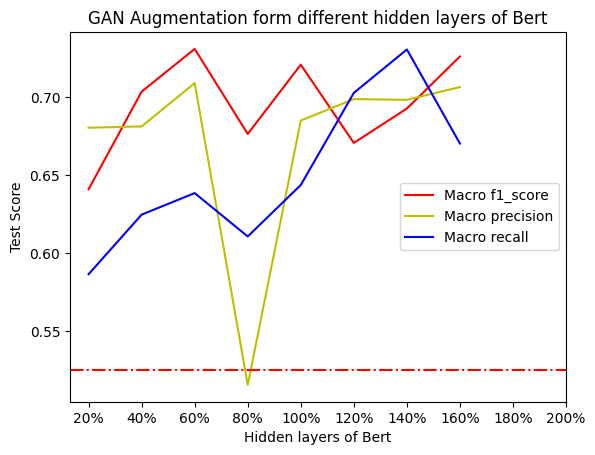

In [19]:
x_label=[str(i*20)+"%" for i in range(1,11)]
import matplotlib.pyplot as plt
# plt.plot(ACCs, label="accuracy")
fig = plt.figure(edgecolor='k', frameon=True)
# fig.patch.set_facecolor('xkcd:blue')
plt.plot(tbk_f1, label="Macro f1_score",color='r')
plt.plot(gan_f1, label="Macro precision",color='y')
plt.plot(hybrid_f1, label="Macro recall",color='b')
plt.axhline(y = 0.525, color = 'r', linestyle = 'dashdot')
plt.xticks([i for i in range(10)],x_label)
plt.xlabel("Hidden layers of Bert")
plt.ylabel("Test Score")
plt.title("GAN Augmentation form different hidden layers of Bert")
plt.legend()
plt.show()

In [ ]:
from google.colab import runtime
runtime.unassign()